In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [3]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [4]:
pred_occu = pred['occupancy_recon'].to(torch.device('cpu'))
pred_flow = pred['flow_recon'].to(torch.device('cpu'))
pred_speed = pred['speed_recon'].to(torch.device('cpu'))

# derivative wrt time t
pred_k_t = pred['k_t'].to(torch.device('cpu'))
pred_k_t_predict = pred['k_t_predict'].to(torch.device('cpu'))

#derivative wrt space x
pred_q_x = pred['q_x'].to(torch.device('cpu'))
pred_v_x = pred['v_x'].to(torch.device('cpu'))
pred_q_xx = pred['q_xx'].to(torch.device('cpu'))
pred_v_xx = pred['v_xx'].to(torch.device('cpu'))


In [5]:
occupancy_recon = torch.cat((X_occu_all, pred_occu), dim=1).detach().numpy()
flow_recon = torch.cat((X_occu_all, pred_flow), dim=1).detach().numpy()
speed_recon = torch.cat((X_occu_all, pred_speed), dim=1).detach().numpy()
k_t = torch.cat((X_occu_all, pred_k_t), dim=1).detach().numpy()
k_t_predict = torch.cat((X_occu_all, pred_k_t_predict), dim=1).detach().numpy()

q_x = torch.cat((X_occu_all, pred_q_x), dim=1).detach().numpy()
v_x = torch.cat((X_occu_all, pred_v_x), dim=1).detach().numpy()
q_xx = torch.cat((X_occu_all, pred_q_xx), dim=1).detach().numpy()
v_xx = torch.cat((X_occu_all, pred_v_xx), dim=1).detach().numpy()

In [6]:
occupancy_recon = pd.DataFrame(occupancy_recon, columns = ['TimeStep','Station_Number','Occupancy'])
flow_recon = pd.DataFrame(flow_recon, columns = ['TimeStep','Station_Number','Flow'])
speed_recon = pd.DataFrame(speed_recon, columns = ['TimeStep','Station_Number','Speed'])

k_t = pd.DataFrame(k_t, columns = ['TimeStep','Station_Number','k_t'])
k_t_predict = pd.DataFrame(k_t_predict, columns=['TimeStep', 'Station_Number', 'k_t'])

q_x = pd.DataFrame(q_x, columns = ['TimeStep', 'Station_Number', 'q_x'])
v_x = pd.DataFrame(v_x, columns = ['TimeStep', 'Station_Number', 'v_x'])

q_xx = pd.DataFrame(q_xx, columns = ['TimeStep', 'Station_Number', 'q_xx'])
v_xx = pd.DataFrame(v_xx, columns = ['TimeStep', 'Station_Number', 'v_xx'])

In [7]:
occupancy_recon['TimeStep'] = occupancy_recon['TimeStep'].astype(int)
occupancy_recon['Station_Number'] = occupancy_recon['Station_Number'].astype(int)
flow_recon['TimeStep'] = flow_recon['TimeStep'].astype(int)
flow_recon['Station_Number'] = flow_recon['Station_Number'].astype(int)
speed_recon['TimeStep'] = speed_recon['TimeStep'].astype(int)
speed_recon['Station_Number'] = speed_recon['Station_Number'].astype(int)

occupancy_recon_wide = occupancy_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
flow_recon_wide = flow_recon.pivot(index='Station_Number', columns='TimeStep', values='Flow')
speed_recon_wide = speed_recon.pivot(index='Station_Number', columns='TimeStep', values='Speed')

q_x_wide = q_x.pivot(index='Station_Number', columns='TimeStep', values='q_x')
v_x_wide = v_x.pivot(index='Station_Number', columns='TimeStep', values='v_x')
q_xx_wide = q_xx.pivot(index='Station_Number', columns='TimeStep', values='q_xx')
v_xx_wide = v_xx.pivot(index='Station_Number', columns='TimeStep', values='v_xx')

In [8]:
# Load True Traffic data
Flow = pd.read_csv('Data_Clean/Flow_all.csv',index_col='Station_PM')
Occupancy = pd.read_csv('Data_Clean/Occupancy_all.csv',index_col='Station_PM')
Speed = pd.read_csv('Data_Clean/Speed_all.csv',index_col='Station_PM')

# Select the first 288 timestep
Occupancy = 100*Occupancy.iloc[:,180:539]
Flow = Flow.iloc[:,180:539]
Speed = Speed.iloc[:,180:539]

In [9]:
loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T
occu_ori = Occupancy.values.T

loc, time = flow_recon_wide.index.values, flow_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
flow_values = flow_recon_wide.values.T
flow_ori = Flow.values.T

loc, time = speed_recon_wide.index.values, speed_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
speed_values = speed_recon_wide.values.T
speed_ori = Speed.values.T

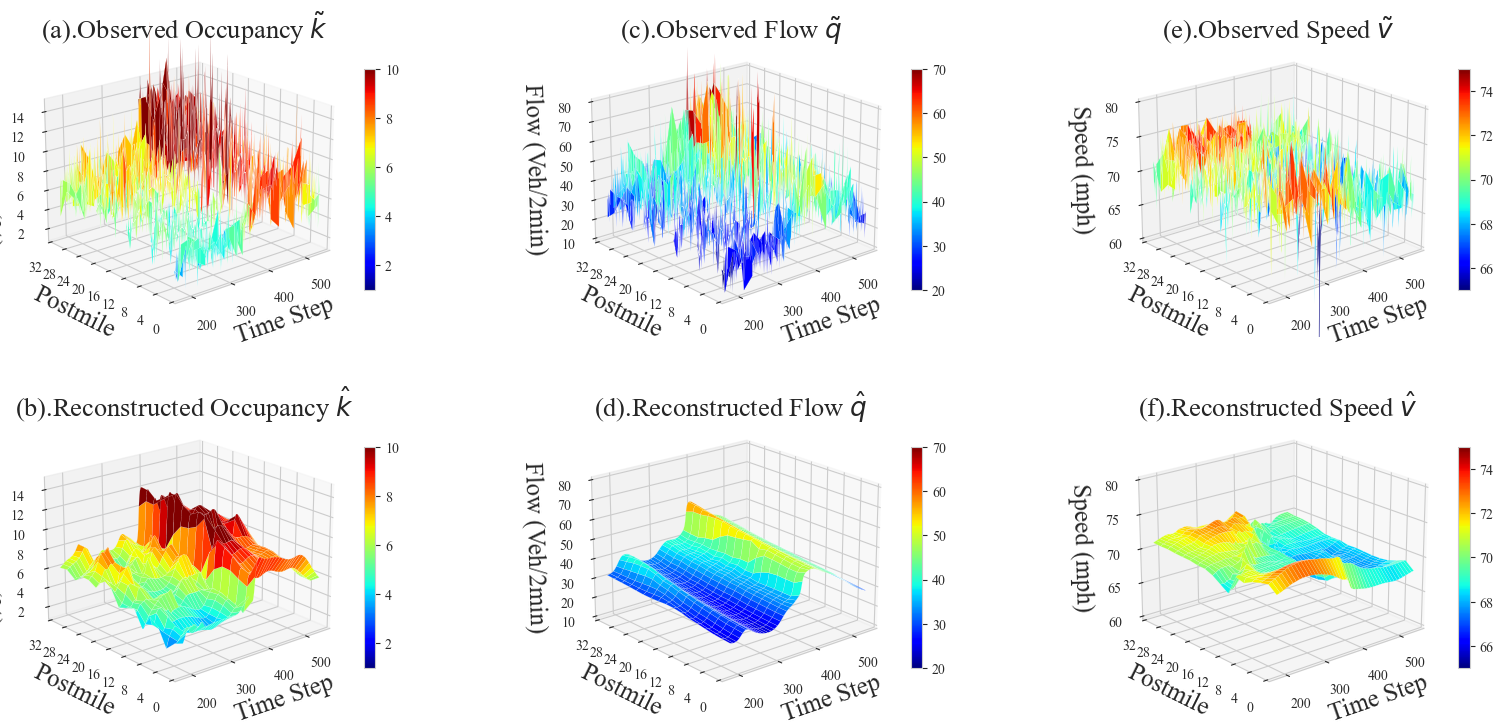

In [67]:
# All
fig = plt.figure(figsize=(20, 9))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim_occu = 15
low_lim_occu = 1

up_lim_flow = 80
low_lim_flow = 10

up_lim_speed = 80
low_lim_speed = 60

norm_occu = plt.Normalize(1, 10)
norm_flow = plt.Normalize(20, 70)
norm_speed = plt.Normalize(65, 75)

loc, time = speed_recon_wide.index.values, speed_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
speed_values = speed_recon_wide.values.T
speed_ori = Speed.values.T

ax1 = fig.add_subplot(231, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_occu)
ax1.set_zlim(low_lim_occu, up_lim_occu)
ax1.view_init(elev=20, azim=230)
ax1.set_xlabel('Time Step', fontsize = 18)
ax1.set_ylabel('Postmile', fontsize = 18)
ax1.set_zlabel('Occupancy (%)', fontsize = 18)
ax1.set_title(r'(a).Observed Occupancy $\tilde{k}$', fontsize = 19, y=1)
ax1.set_ylim(0,16)
yticks = ax1.get_yticks()  # Get current yticks
ax1.set_yticks(yticks)  # Set yticks explicitly
ax1.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks]) 


ax2 = fig.add_subplot(234, projection='3d')
surf2 = ax2.plot_surface(time, loc, occu_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_occu)
ax2.set_zlim(low_lim_occu, up_lim_occu)
ax2.view_init(elev=20, azim=230)
ax2.set_xlabel('Time Step', fontsize = 18)
ax2.set_ylabel('Postmile', fontsize = 18)
ax2.set_zlabel('Occupancy (%)', fontsize = 18)
ax2.set_title(r'(b).Reconstructed Occupancy $\hat{k}$', fontsize = 19, y=1)
ax2.set_ylim(0,16)
yticks2 = ax2.get_yticks()  # Get current yticks
ax2.set_yticks(yticks2)  # Set yticks explicitly
ax2.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks2]) 

ax3 = fig.add_subplot(232, projection='3d')
surf3 = ax3.plot_surface(time, loc, flow_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_flow)
ax3.set_zlim(low_lim_flow, up_lim_flow)
ax3.view_init(elev=20, azim=230)
ax3.set_xlabel('Time Step', fontsize = 18)
ax3.set_ylabel('Postmile', fontsize = 18)
ax3.set_zlabel('Flow (Veh/2min)', fontsize = 18)
ax3.set_title(r'(c).Observed Flow $\tilde{q}$', fontsize = 19, y=1)
ax3.set_ylim(0,16)
yticks3 = ax1.get_yticks()  # Get current yticks
ax3.set_yticks(yticks3)  # Set yticks explicitly
ax3.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks3]) 

ax4 = fig.add_subplot(235, projection='3d')
surf4 = ax4.plot_surface(time, loc, flow_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_flow)
ax4.set_zlim(low_lim_flow, up_lim_flow)
ax4.view_init(elev=20, azim=230)
ax4.set_xlabel('Time Step', fontsize = 18)
ax4.set_ylabel('Postmile', fontsize = 18)
ax4.set_zlabel('Flow (Veh/2min)', fontsize = 18)
ax4.set_title(r'(d).Reconstructed Flow $\hat{q}$', fontsize = 19, y=1)
ax4.set_ylim(0,16)
yticks4 = ax1.get_yticks()  # Get current yticks
ax4.set_yticks(yticks4)  # Set yticks explicitly
ax4.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks4]) 

ax5 = fig.add_subplot(233, projection='3d')
surf5 = ax5.plot_surface(time, loc, speed_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_speed)
ax5.set_zlim(low_lim_speed, up_lim_speed)
ax5.view_init(elev=20, azim=230)
ax5.set_xlabel('Time Step', fontsize = 18)
ax5.set_ylabel('Postmile', fontsize = 18)
ax5.set_zlabel('Speed (mph)', fontsize = 18)
ax5.set_title(r'(e).Observed Speed $\tilde{v}$', fontsize = 19, y=1)
ax5.set_ylim(0,16)
yticks5 = ax1.get_yticks()  # Get current yticks
ax5.set_yticks(yticks5)  # Set yticks explicitly
ax5.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks5]) 

ax6 = fig.add_subplot(236, projection='3d')
surf6 = ax6.plot_surface(time, loc, speed_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_speed)
ax6.set_zlim(low_lim_speed, up_lim_speed)
ax6.view_init(elev=20, azim=230)
ax6.set_xlabel('Time Step', fontsize = 18)
ax6.set_ylabel('Postmile', fontsize = 18)
ax6.set_zlabel('Speed (mph)', fontsize = 18)
ax6.set_title(r'(f).Reconstructed Speed $\hat{v}$', fontsize = 19, y=1)
ax6.set_ylim(0,16)
yticks6 = ax1.get_yticks()  # Get current yticks
ax6.set_yticks(yticks6)  # Set yticks explicitly
ax6.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks6]) 

fig.colorbar(surf1, ax=ax1, shrink=0.7)
fig.colorbar(surf2, ax=ax2, shrink=0.7)
fig.colorbar(surf3, ax=ax3, shrink=0.7)
fig.colorbar(surf4, ax=ax4, shrink=0.7)
fig.colorbar(surf5, ax=ax5, shrink=0.7)
fig.colorbar(surf6, ax=ax6, shrink=0.7)

plt.rcParams['font.family'] = 'Times New Roman'
# plt.tight_layout()
plt.show()
fig.savefig("Figures/Reconstruction/Recon_3D.png",bbox_inches='tight', dpi = 300)

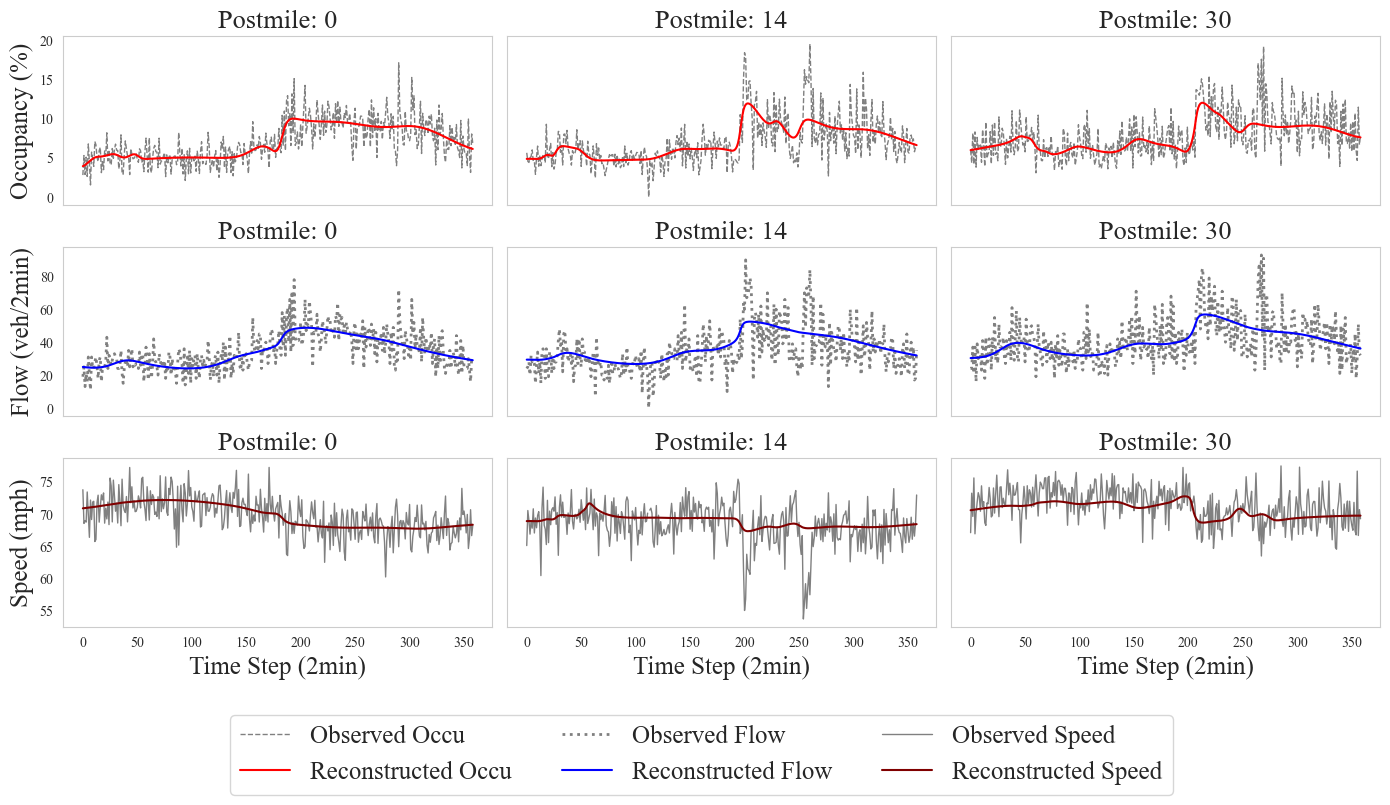

In [102]:
fig, axs = plt.subplots(3, 3, figsize=(14, 7), sharey='row', sharex=True)

axs[0,0].plot(Occupancy.values[0,:], linewidth = 1, linestyle='--', color = 'grey', label = "Observed Occu")
axs[0,0].plot(occupancy_recon_wide.values[0,:], linewidth = 1.5, color = 'red', label = "Reconstructed Occu")
axs[0,0].set_title('Postmile: 0', fontsize = 19)

axs[0,1].plot(Occupancy.values[7,:], linewidth = 1, linestyle='--', color = 'grey')
axs[0,1].plot(occupancy_recon_wide.values[7,:], linewidth = 1.5, color = 'red')
axs[0,1].set_title('Postmile: 14', fontsize = 19)

axs[0,2].plot(Occupancy.values[15,:], linewidth = 1, linestyle='--', color = 'grey')
axs[0,2].plot(occupancy_recon_wide.values[15,:], linewidth = 1.5, color = 'red')
axs[0,2].set_title('Postmile: 30', fontsize = 19)

# axs[0,3].plot(Occupancy.values[16,:], linewidth = 1, linestyle='--', color = 'grey')
# axs[0,3].plot(occupancy_recon_wide.values[16,:], linewidth = 1.5, color = 'red')
# axs[0,3].set_title('Postmile: 32', fontsize = 18)

axs[1,0].plot(Flow.values[0,:], linewidth = 2, linestyle=':', color = 'grey' , label = "Observed Flow")
axs[1,0].plot(flow_recon_wide.values[0,:], linewidth = 1.5, color = 'blue', label = "Reconstructed Flow")
axs[1,0].set_title('Postmile: 0', fontsize = 19)

axs[1,1].plot(Flow.values[7,:], linewidth = 2, linestyle=':', color = 'grey')
axs[1,1].plot(flow_recon_wide.values[7,:], linewidth = 1.5, color = 'blue')
axs[1,1].set_title('Postmile: 14', fontsize = 19)

axs[1,2].plot(Flow.values[15,:], linewidth = 2, linestyle=':', color = 'grey')
axs[1,2].plot(flow_recon_wide.values[15,:], linewidth = 1.5, color = 'blue')
axs[1,2].set_title('Postmile: 30', fontsize = 19)

# axs[1,3].plot(Flow.values[16,:], linewidth = 2, linestyle=':', color = 'grey')
# axs[1,3].plot(flow_recon_wide.values[16,:], linewidth = 1.5, color = 'blue')
# axs[1,3].set_title('Postmile: 32', fontsize = 18)

axs[2,0].plot(Speed.values[0,:], linewidth = 1, color = 'grey' , label = "Observed Speed")
axs[2,0].plot(speed_recon_wide.values[0,:], linewidth = 1.5, color = 'maroon', label = "Reconstructed Speed")
axs[2,0].set_title('Postmile: 0', fontsize = 19)

axs[2,1].plot(Speed.values[7,:], linewidth = 1, color = 'grey')
axs[2,1].plot(speed_recon_wide.values[7,:], linewidth = 1.5, color = 'maroon')
axs[2,1].set_title('Postmile: 14', fontsize = 19)

axs[2,2].plot(Speed.values[15,:], linewidth = 1, color = 'grey')
axs[2,2].plot(speed_recon_wide.values[15,:], linewidth = 1.5, color = 'maroon')
axs[2,2].set_title('Postmile: 30', fontsize = 19)

# axs[2,3].plot(Speed.values[16,:], linewidth = 1, color = 'grey')
# axs[2,3].plot(speed_recon_wide.values[16,:], linewidth = 1.5, color = 'maroon')
# axs[2,3].set_title('Postmile: 32', fontsize = 18)

for i in range(0,3):
    for j in range(0,3):
        axs[i,j].grid(False)

for c in range(0,3):
    axs[2,c].set_xlabel('Time Step (2min)', fontsize = 18)

axs[0,0].set_ylabel('Occupancy (%)', fontsize = 18)
axs[1,0].set_ylabel('Flow (veh/2min)', fontsize = 18)
axs[2,0].set_ylabel('Speed (mph)', fontsize = 18)

handles_0, labels_0 = axs[0,0].get_legend_handles_labels()
handles_1, labels_1 = axs[1,0].get_legend_handles_labels()
handles_2, labels_2 = axs[2,0].get_legend_handles_labels()

handles = handles_0 + handles_1 + handles_2
labels = labels_0 + labels_1 + labels_2

lgd = fig.legend(handles, labels, bbox_to_anchor=(0.85,-0.01), fontsize=18, ncol = 3)

plt.tight_layout()
fig.savefig("Figures/Reconstruction/Recon_Line_Plots.png",bbox_inches='tight', dpi = 300)

In [12]:
# Reconstruction RMSE
squared_error = (occu_ori - occu_values) ** 2
mean_squared_error = np.nanmean(squared_error)
rmse_occu = np.sqrt(mean_squared_error)

squared_error = (flow_ori - flow_values) ** 2
mean_squared_error = np.nanmean(squared_error)
rmse_flow = np.sqrt(mean_squared_error)

squared_error = (speed_ori - speed_values) ** 2
mean_squared_error = np.nanmean(squared_error)
rmse_speed = np.sqrt(mean_squared_error)

print(rmse_occu)
print(rmse_flow)
print(rmse_speed)

2.070161427387171
10.405385068882344
2.6987187325445166


In [13]:
with np.errstate(divide='ignore', invalid='ignore'):
    APE = np.abs((occu_ori - occu_values) / occu_ori)
    APE = np.where(occu_ori == 0, np.nan, APE)  # Replace division by zero with NaN

# Calculate MAPE, ignoring NaN values
mape_occu = np.nanmean(APE) * 100  # MAPE is often expressed as a percentage

with np.errstate(divide='ignore', invalid='ignore'):
    APE = np.abs((flow_ori - flow_values) / flow_ori)
    APE = np.where(flow_ori == 0, np.nan, APE)  # Replace division by zero with NaN

# Calculate MAPE, ignoring NaN values
mape_flow = np.nanmean(APE) * 100  # MAPE is often expressed as a percentage

with np.errstate(divide='ignore', invalid='ignore'):
    APE = np.abs((speed_ori - speed_values) / speed_ori)
    APE = np.where(speed_ori == 0, np.nan, APE)  # Replace division by zero with NaN

# Calculate MAPE, ignoring NaN values
mape_speed = np.nanmean(APE) * 100  # MAPE is often expressed as a percentage

print(mape_occu)
print(mape_flow)
print(mape_speed)

23.72598068911489
23.883401125842568
2.9957059116774207


In [14]:
k_t['TimeStep'] = k_t['TimeStep'].astype(int)
k_t['Station_Number'] = k_t['Station_Number'].astype(int)

k_t_predict['TimeStep'] = k_t_predict['TimeStep'].astype(int)
k_t_predict['Station_Number'] = k_t_predict['Station_Number'].astype(int)

k_t_wide = k_t.pivot(index='Station_Number', columns='TimeStep', values='k_t')
k_t_predict_wide = k_t_predict.pivot(index='Station_Number', columns='TimeStep', values='k_t')

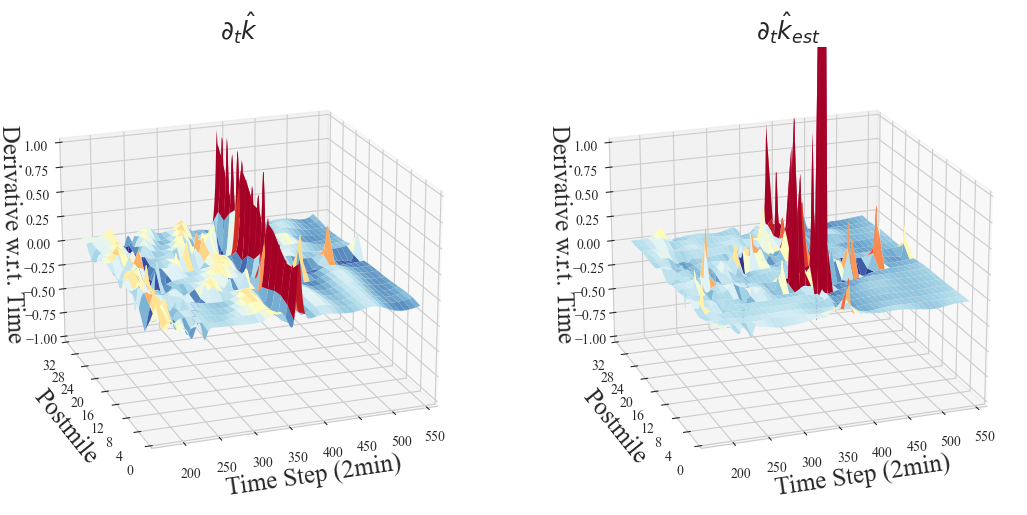

In [18]:
fig = plt.figure(figsize=(13, 6))
plt.rcParams['font.family'] = 'Times New Roman'

loc, time = k_t_wide.index.values, k_t_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
kt_values = k_t_wide.values.T
kt_predict_values = k_t_predict_wide.values.T

up_lim = 0.2
low_lim = -0.1
norm = plt.Normalize(low_lim, up_lim)

ax2 = fig.add_subplot(121, projection='3d')
surf3 = ax2.plot_surface(time, loc, kt_values, cmap='RdYlBu_r', linewidth=0.02, antialiased=True, norm = norm)

ax2.view_init(elev=20, azim=250)
ax2.set_xlabel('Time Step (2min)', fontsize = 18)
ax2.set_ylabel('Postmile', fontsize = 18)
ax2.set_zlabel('Derivative w.r.t. Time', fontsize = 18)
ax2.set_title(r'$\partial_t \hat{k}$', fontsize = 18)
ax2.set_zlim(-1, 1)
ax2.set_ylim(0,16)

# Set yticks and labels for ax2 
yticks = ax2.get_yticks()  # Get current yticks
ax2.set_yticks(yticks)  # Set yticks explicitly
ax2.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks]) 

ax3 = fig.add_subplot(122, projection='3d')
surf4 = ax3.plot_surface(time, loc, kt_predict_values, cmap='RdYlBu_r', linewidth=0.02, antialiased=True, norm = norm)

ax3.view_init(elev=20, azim=250)
ax3.set_xlabel('Time Step (2min)', fontsize = 18)
ax3.set_ylabel('Postmile', fontsize = 18)
ax3.set_zlabel('Derivative w.r.t. Time', fontsize = 18)
ax3.set_title(r'$\partial_t \hat{k}_{est}$', fontsize = 18)
ax3.set_zlim(-1, 1)
ax3.set_ylim(0,16)

# Set yticks and labels for ax3
yticks2 = ax3.get_yticks()  # Get current yticks
ax3.set_yticks(yticks2)  # Set yticks explicitly
ax3.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks2])

# plt.tight_layout()
plt.show()
fig.savefig("Figures/k_t_3D.png", dpi = 300, bbox_inches = 'tight')

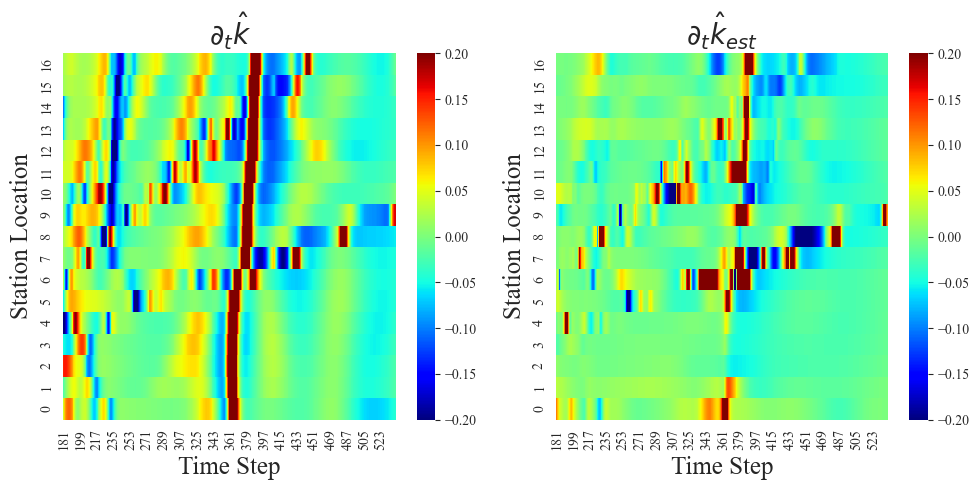

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

vmin, vmax = -0.2, 0.2
sns.heatmap(k_t_wide.iloc[::-1], cmap='jet', vmin=vmin, vmax=vmax, annot=False, robust=True, ax=axs[0])
axs[0].set_ylabel('Station Location',  fontsize = 18)
axs[0].set_xlabel('Time Step',  fontsize = 18)
axs[0].set_title(r'$\partial_t \hat{k}$',  fontsize = 20)

sns.heatmap(k_t_predict_wide.iloc[::-1], cmap='jet', vmin=vmin, vmax=vmax, annot=False,robust=True, ax=axs[1])
axs[1].set_ylabel('Station Location',  fontsize = 18)
axs[1].set_xlabel('Time Step',  fontsize = 18)
axs[1].set_title(r'$\partial_t \hat{k}_{est}$ ',  fontsize = 20)

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures/k_dev.png", dpi = 300)

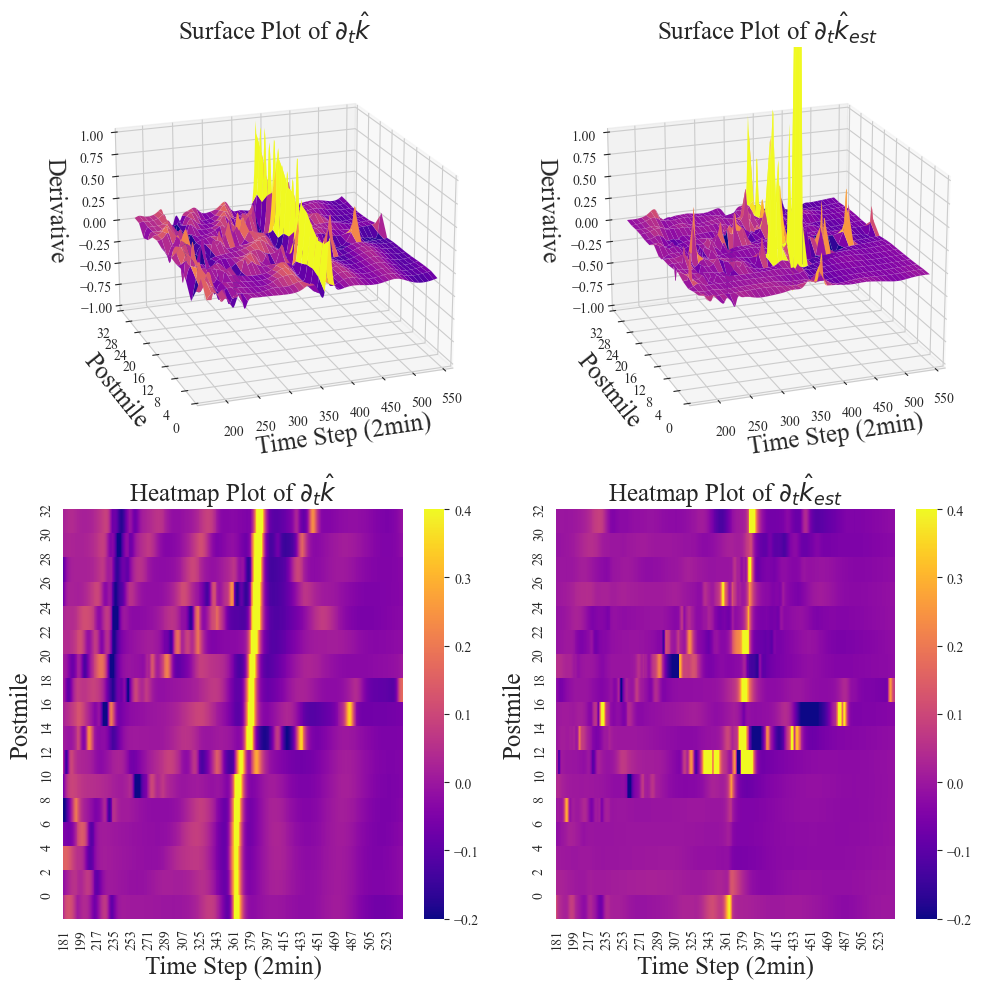

In [54]:
# Create a figure with four subplots
fig = plt.figure(figsize=(10, 10))
plt.rcParams['font.family'] = 'Times New Roman'

# Prepare meshgrid for the 3D plots
loc, time = k_t_wide.index.values, k_t_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
kt_values = k_t_wide.values.T
kt_predict_values = k_t_predict_wide.values.T

# Set color limits for normalization
up_lim = 0.2
low_lim = -0.1
norm = plt.Normalize(low_lim, up_lim)

# First 3D plot
ax1 = fig.add_subplot(221, projection='3d')
surf1 = ax1.plot_surface(time, loc, kt_values, cmap='plasma', linewidth=0.02, antialiased=True, norm=norm)
ax1.view_init(elev=20, azim=250)
ax1.set_xlabel('Time Step (2min)', fontsize=18)
ax1.set_ylabel('Postmile', fontsize=18)
ax1.set_zlabel('Derivative', fontsize=18, labelpad=10)
ax1.set_title(r'Surface Plot of $\partial_t \hat{k}$', fontsize=18)
ax1.set_zlim(-1, 1)
ax1.set_ylim(0, 16)
# Set yticks and labels for ax1
yticks = ax1.get_yticks()
ax1.set_yticks(yticks)
ax1.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks])

# Second 3D plot
ax2 = fig.add_subplot(222, projection='3d')
surf2 = ax2.plot_surface(time, loc, kt_predict_values, cmap='plasma', linewidth=0.02, antialiased=True, norm=norm)
ax2.view_init(elev=20, azim=250)
ax2.set_xlabel('Time Step (2min)', fontsize=18)
ax2.set_ylabel('Postmile', fontsize=18)
ax2.set_zlabel('Derivative', fontsize=18, labelpad=10)
ax2.set_title(r'Surface Plot of $\partial_t \hat{k}_{est}$', fontsize=18)
ax2.set_zlim(-1, 1)
ax2.set_ylim(0, 16)
# Set yticks and labels for ax2
yticks2 = ax2.get_yticks()
ax2.set_yticks(yticks2)
ax2.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks2])

# First heatmap
ax3 = fig.add_subplot(223)
sns.heatmap(k_t_wide.iloc[::-1], cmap='plasma', vmin=-0.2, vmax=0.4, annot=False, robust=True, ax=ax3)
ax3.set_ylabel('Postmile', fontsize=18)
ax3.set_xlabel('Time Step (2min)', fontsize=18)
ax3.set_title(r'Heatmap Plot of $\partial_t \hat{k}$', fontsize=18)
# ax3.set_ylim(0, 16)
ax3.set_yticks(np.arange(0, 17, 1))
yticks3 = ax3.get_yticks()
ax3.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks3[::-1]])

# Second heatmap
ax4 = fig.add_subplot(224)
sns.heatmap(k_t_predict_wide.iloc[::-1], cmap='plasma', vmin=-0.2, vmax=0.4, annot=False, robust=True, ax=ax4)
ax4.set_ylabel('Postmile', fontsize=18)
ax4.set_xlabel('Time Step (2min)', fontsize=18)
ax4.set_title(r'Heatmap Plot of $\partial_t \hat{k}_{est}$', fontsize=18)
ax4.set_yticks(np.arange(0, 17, 1))
yticks4 = ax4.get_yticks()
ax4.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks4[::-1]])

# Adjust layout and save the combined figure
plt.tight_layout()
plt.show()
fig.savefig("Figures/combined_k_t_plots.png", dpi=300, bbox_inches='tight')

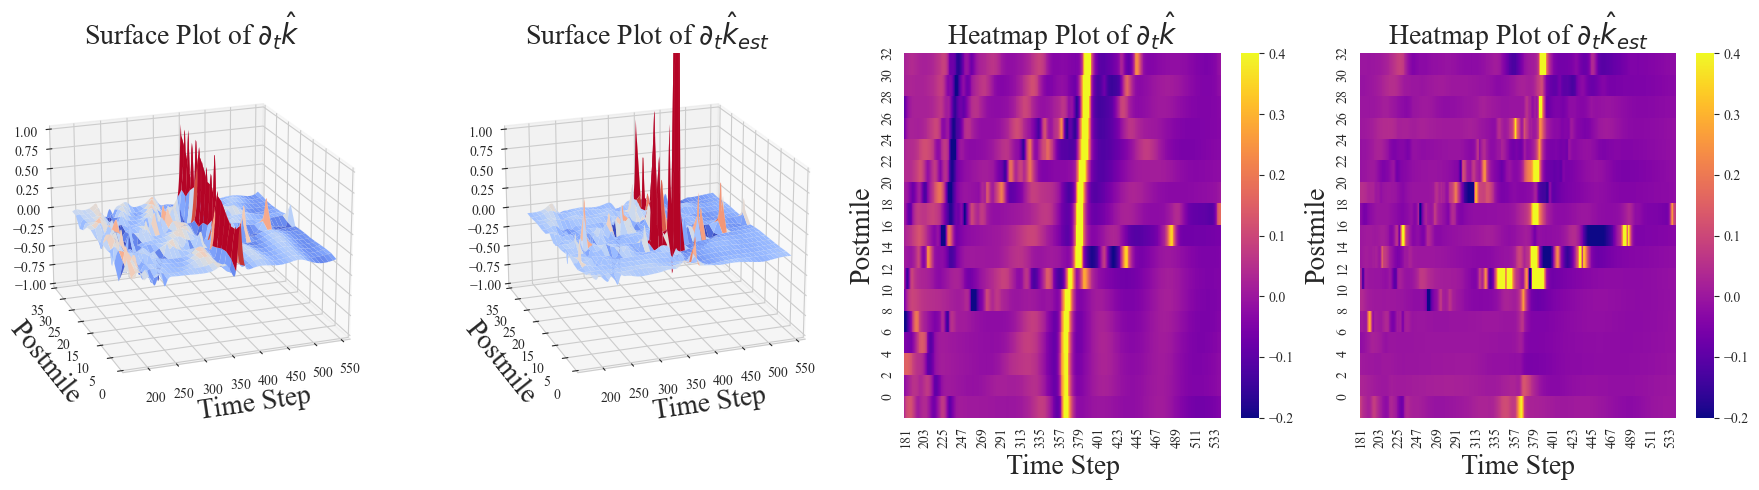

In [176]:
# Create a figure with a 1x4 layout
fig = plt.figure(figsize=(18, 5))
plt.rcParams['font.family'] = 'Times New Roman'

# Prepare meshgrid for the 3D plots
loc, time = k_t_wide.index.values, k_t_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
kt_values = k_t_wide.values.T
kt_predict_values = k_t_predict_wide.values.T

# Set color limits for normalization
up_lim = 0.2
low_lim = -0.1
norm = plt.Normalize(low_lim, up_lim)

# First 3D plot
ax1 = fig.add_subplot(141, projection='3d')
surf1 = ax1.plot_surface(time, loc, kt_values, cmap='coolwarm', linewidth=0.02, antialiased=True, norm=norm)
ax1.view_init(elev=20, azim=250)
ax1.set_xlabel('Time Step', fontsize=20)
ax1.set_ylabel('Postmile', fontsize=20)
# ax1.set_zlabel('Derivative', fontsize=18, labelpad=5)
ax1.set_title(r'Surface Plot of $\partial_t \hat{k}$', fontsize=20)
ax1.set_zlim(-1, 1)
ax1.set_ylim(0, 16)
# Set yticks and labels for ax1
yticks = ax1.get_yticks()
ax1.set_yticks(yticks)
ax1.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks])

# Second 3D plot
ax2 = fig.add_subplot(142, projection='3d')
surf2 = ax2.plot_surface(time, loc, kt_predict_values, cmap='coolwarm', linewidth=0.02, antialiased=True, norm=norm)
ax2.view_init(elev=20, azim=250)
ax2.set_xlabel('Time Step', fontsize=20)
ax2.set_ylabel('Postmile', fontsize=20)
# ax2.set_zlabel('Derivative', fontsize=18, labelpad=5)
ax2.set_title(r'Surface Plot of $\partial_t \hat{k}_{est}$', fontsize=20)
ax2.set_zlim(-1, 1)
ax2.set_ylim(0, 16)
# Set yticks and labels for ax2
yticks2 = ax2.get_yticks()
ax2.set_yticks(yticks2)
ax2.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks2])

# First heatmap
ax3 = fig.add_subplot(143)
sns.heatmap(k_t_wide.iloc[::-1], cmap='plasma', vmin=-0.2, vmax=0.4, annot=False, robust=True, ax=ax3)
ax3.set_ylabel('Postmile', fontsize=20)
ax3.set_xlabel('Time Step', fontsize=20)
ax3.set_title(r'Heatmap Plot of $\partial_t \hat{k}$', fontsize=20)
ax3.set_yticks(np.arange(0, 17, 1))
yticks3 = ax3.get_yticks()
ax3.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks3[::-1]])

# Second heatmap
ax4 = fig.add_subplot(144)
sns.heatmap(k_t_predict_wide.iloc[::-1], cmap='plasma', vmin=-0.2, vmax=0.4, annot=False, robust=True, ax=ax4)
ax4.set_ylabel('Postmile', fontsize=20)
ax4.set_xlabel('Time Step', fontsize=20)
ax4.set_title(r'Heatmap Plot of $\partial_t \hat{k}_{est}$', fontsize=20)
ax4.set_yticks(np.arange(0, 17, 1))
yticks4 = ax4.get_yticks()
ax4.set_yticklabels([f'{ytick * 2:.0f}' for ytick in yticks4[::-1]])

# Adjust layout and save the combined figure
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.show()
fig.savefig("Figures/combined_k_t_plots.png", dpi=300, bbox_inches='tight')


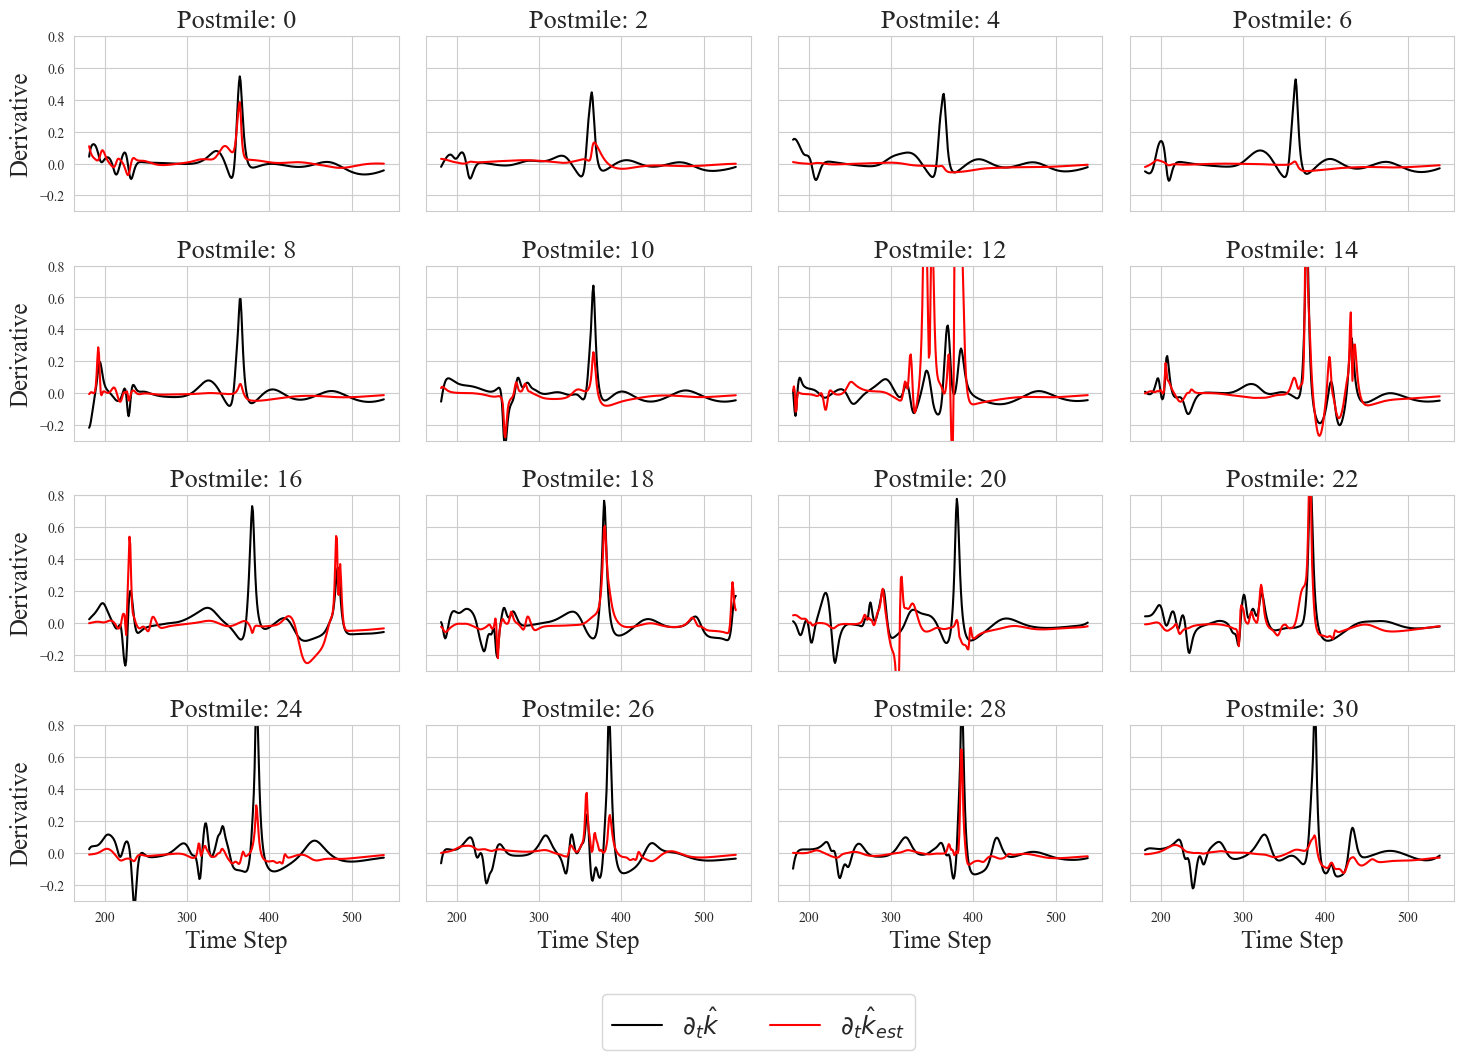

In [98]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
# Plotting the data for each row in both dataframes
for i in range(16):
    # Plot the data
    axes[i].plot(k_t_wide.iloc[i, :], label=r'$\partial_t \hat{k}$', color = 'black')
    axes[i].plot(k_t_predict_wide.iloc[i, :], label=r'$\partial_t \hat{k}_{est}$', color = 'red')
    axes[i].set_title(f'Postmile: {i * 2}', fontsize=19)
    axes[i].set_ylim(-0.3, 0.8)
    # axes[i].legend(loc='upper right', fontsize=12)

    # Add x-axis labels only for the subplots in the last row
    if i >= 12:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=18)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Derivative', fontsize=18)

handles, labels = axes[0].get_legend_handles_labels()

lgd = fig.legend(handles, labels, bbox_to_anchor=(0.63,0), fontsize=18, ncol = 2)

plt.tight_layout(pad=2.0)
fig.savefig("Figures/k_t_lines.png", dpi=300, bbox_inches='tight')

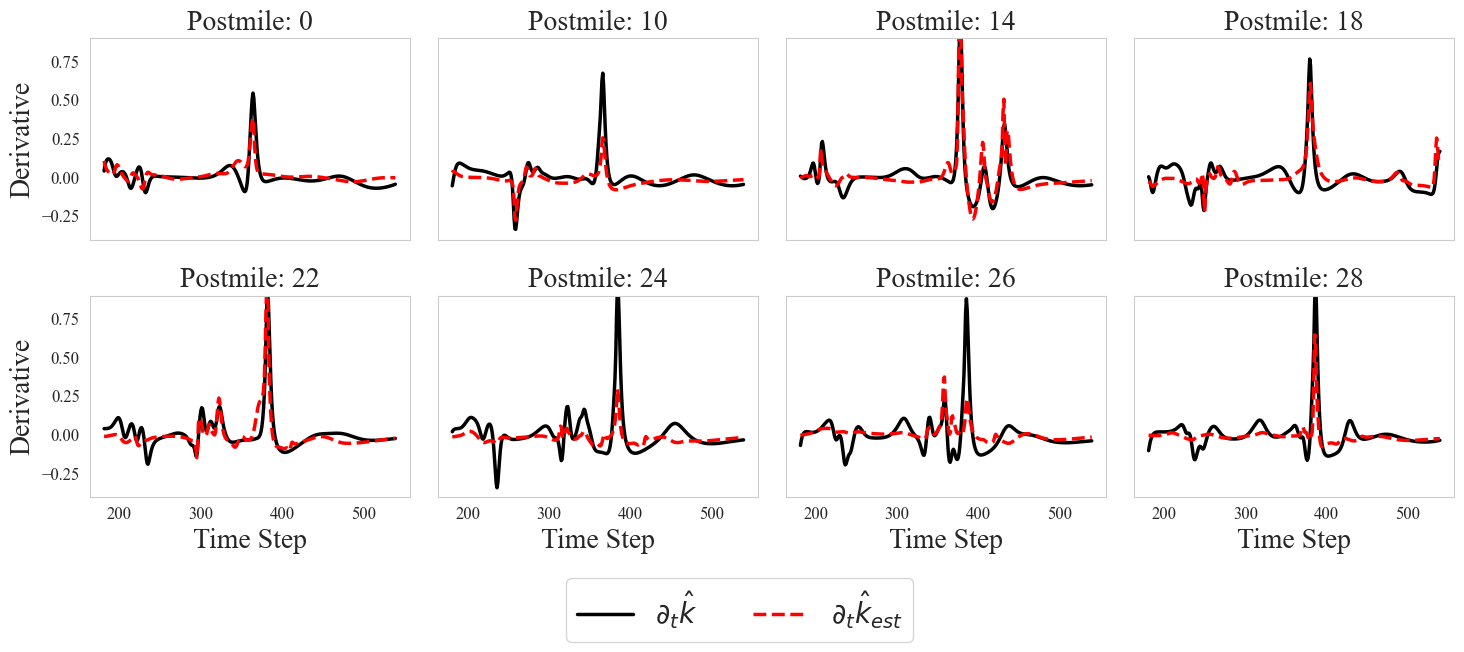

In [133]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()
# select the postmiles (total 8) we need to include in the plot
select_postmile = [0, 5, 7, 9, 11, 12, 13, 14]
for i in range(8):
    # Plot the data
    col = select_postmile[i]
    axes[i].plot(k_t_wide.iloc[col, :], label=r'$\partial_t \hat{k}$', linewidth= 2.5, linestyle = '-', color = 'black')
    axes[i].plot(k_t_predict_wide.iloc[col, :], label=r'$\partial_t \hat{k}_{est}$', linewidth= 2.5,  linestyle = '--', color = 'red')
    axes[i].set_title(f'Postmile: {col * 2}', fontsize=20)
    axes[i].set_ylim(-0.4, 0.9)
    # axes[i].legend(loc='upper right', fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    # Add x-axis labels only for the subplots in the last row
    if i >= 4:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=20)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Derivative', fontsize=20)
    axes[i].grid(False)

handles, labels = axes[0].get_legend_handles_labels()

lgd = fig.legend(handles, labels, bbox_to_anchor=(0.63,0.03), fontsize=20, ncol = 2)

plt.tight_layout(pad=2.0)
fig.savefig("Figures/k_t_lines_select.png", dpi=300, bbox_inches='tight')

In [27]:
squared_error = (k_t_wide.iloc[::-1] - k_t_predict_wide.iloc[::-1]) ** 2
mean_squared_error = np.nanmean(squared_error)
rmse_occu = np.sqrt(mean_squared_error)
rmse_occu

0.17710517

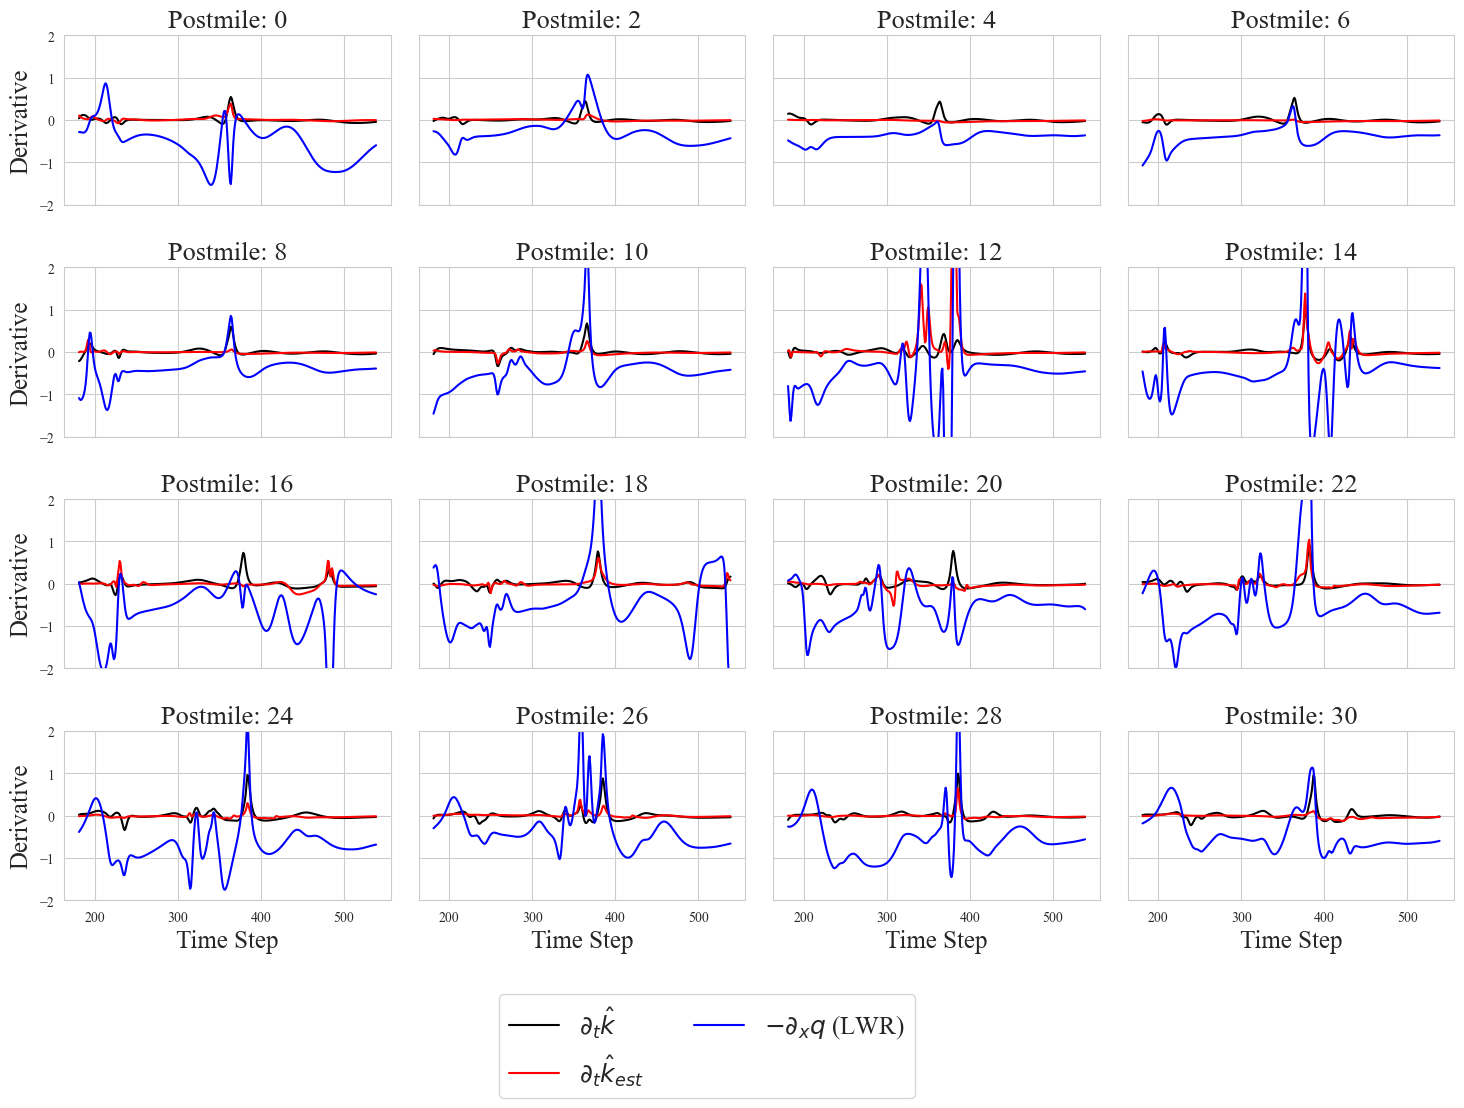

In [113]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
# Plotting the data for each row in both dataframes
for i in range(16):
    # Plot the data
    axes[i].plot(k_t_wide.iloc[i, :], label=r'$\partial_t \hat{k}$', color = 'black')
    axes[i].plot(k_t_predict_wide.iloc[i, :], label=r'$\partial_t \hat{k}_{est}$', color = 'red')
    axes[i].plot(-q_x_wide.iloc[i, :], label=r'$-\partial_x q$ (LWR)', color = 'blue')
    axes[i].set_title(f'Postmile: {i * 2}', fontsize=19)
    axes[i].set_ylim(-2, 2)
    # axes[i].legend(loc='upper right', fontsize=12)

    # Add x-axis labels only for the subplots in the last row
    if i >= 12:  # Subplots 12 to 15 correspond to the last row (index starts from 0)
        axes[i].set_xlabel('Time Step', fontsize=18)

    # Add y-axis labels only for the subplots in the first column
    if i % 4 == 0:  # Subplots 0, 4, 8, 12 correspond to the first column
        axes[i].set_ylabel('Derivative', fontsize=18)

handles, labels = axes[0].get_legend_handles_labels()

lgd = fig.legend(handles, labels, bbox_to_anchor=(0.63,0), fontsize=18, ncol = 2)

plt.tight_layout(pad=2.0)
fig.savefig("Figures/k_t_lines_LWR.png", dpi=300, bbox_inches='tight')